In [2]:
from hwmon import Hwmon
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import subprocess
import time
import glob
sns.set()

In [3]:
sensors = Hwmon.HW()
geekbench_location = '/home/robert/geekbench/geekbench_x86_64'

In [4]:
def record_sensor_data(df):
    sensor_data = sensors.data()
    df.loc[len(df)] = {
        'timestamp': datetime.datetime.now(),
        'cpu': sensor_data['thinkpad']['temp1'],
        'gpu': sensor_data['amdgpu']['edge'],
        'fan': sensor_data['thinkpad']['fan1'],
    }
    #print('CPU: {}\tGPU: {}\tFan: {}'.format(
        #sensor_data['thinkpad']['temp1'], 
        #sensor_data['amdgpu']['edge'], 
        #sensor_data['thinkpad']['fan1']))

def run_geekbench_and_monitor(df):
    p = subprocess.Popen(geekbench_location, stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
    while(p.poll() is None):
        record_sensor_data(df)
        time.sleep(1)
    output, err = p.communicate()
    print(output)

def take_idle_temp(df):
    print('Waiting 5 seconds...')
    time.sleep(5)
    print('Recording idle temps...')
    time_started = datetime.datetime.now()
    end_time = time_started + datetime.timedelta(minutes=1)
    
    while(datetime.datetime.now() < end_time):
        record_sensor_data(df)
        # Probe every 2 seconds to avoid taxing CPU
        time.sleep(2)
    print('Done!')

df_template = pd.DataFrame(columns=['timestamp', 'cpu', 'gpu', 'fan'])


In [13]:
geekbench_temps_1 = df_template.copy()
geekbench_temps_2 = df_template.copy()
geekbench_temps_3 = df_template.copy()

for temps in [geekbench_temps_1, geekbench_temps_2, geekbench_temps_3]:
    print('Running GeekBench...')
    run_geekbench_and_monitor(temps)

Running GeekBench...
b'Geekbench 5.4.1 Tryout : https://www.geekbench.com/\n\nGeekbench 5 requires an active Internet connection when in tryout mode and \nautomatically uploads benchmark results to the Geekbench Browser.\n\nBuy a Geekbench 5 license from the Primate Labs Store to enable offline use \nand unlock other features:\n\n  https://store.primatelabs.com/v5\n\nEnter your Geekbench 5 license using the following command line:\n\n  /home/robert/geekbench/geekbench_x86_64 --unlock <email> <key>\n\n  Running Gathering system information\nSystem Information\n  Operating System              Manjaro Linux\n  Kernel                        Linux 5.10.42-1-MANJARO x86_64\n  Model                         LENOVO 20UHCTO1WW\n  Motherboard                   LENOVO 20UHCTO1WW\n  BIOS                          LENOVO R1CET63W(1.32 )\n\nProcessor Information\n  Name                          AMD Ryzen 7 PRO 4750U\n  Topology                      1 Processor, 8 Cores, 16 Threads\n  Identifier       

In [4]:
idle_temp_thinkfan = df_template.copy()
idle_temp_no_thinkfan = df_template.copy()

take_idle_temp(idle_temp_thinkfan)

Waiting 5 seconds...
Recording idle temps...
Done!


In [15]:
geekbench_temps_1.to_csv('after/thinkfan/geekbench_1_1226_6419.csv')
geekbench_temps_2.to_csv('after/thinkfan/geekbench_2_1218_6070.csv')
geekbench_temps_3.to_csv('after/thinkfan/geekbench_3_1217_5960.csv')

In [7]:
#take_idle_temp(idle_temp_thinkfan)
idle_temp_thinkfan.to_csv('after/thinkfan/idle.csv')
idle_temp_no_thinkfan.to_csv('after/no_thinkfan/idle.csv')

In [16]:
#take_idle_temp(idle_temp_thinkfan)
geekbench_temps_3

,timestamp,cpu,gpu,fan
0,2021-06-14 18:08:21.621947,71.0 C,55.0 C,5500 RPM
1,2021-06-14 18:08:22.670102,70.0 C,54.0 C,5500 RPM
2,2021-06-14 18:08:23.729101,68.0 C,53.0 C,5500 RPM
3,2021-06-14 18:08:24.790801,67.0 C,53.0 C,5600 RPM
4,2021-06-14 18:08:25.835654,65.0 C,52.0 C,5500 RPM
...,...,...,...,...
149,2021-06-14 18:10:58.045228,73.0 C,59.0 C,5600 RPM
150,2021-06-14 18:10:59.104220,72.0 C,58.0 C,5600 RPM
151,2021-06-14 18:11:00.183647,80.0 C,59.0 C,5600 RPM
152,2021-06-14 18:11:01.285865,77.0 C,58.0 C,5600 RPM


In [6]:
def convert_to_numeric(df):
    modified = df.copy()
    modified['cpu'] = pd.to_numeric(modified.cpu.str.replace(' C', ''))
    modified['gpu'] = pd.to_numeric(modified.gpu.str.replace(' C', ''))
    modified['fan'] = pd.to_numeric(modified.fan.str.replace(' RPM', ''))
    modified['timestamp'] = pd.to_datetime(modified.timestamp)
    return modified

before_no_thinkfan_idle = convert_to_numeric(pd.read_csv('before/no_thinkfan/idle.csv'))
before_thinkfan_idle = convert_to_numeric(pd.read_csv('before/thinkfan/idle.csv'))
after_no_thinkfan_idle = convert_to_numeric(pd.read_csv('after/no_thinkfan/idle.csv'))
after_thinkfan_idle = convert_to_numeric(pd.read_csv('after/thinkfan/idle.csv'))

In [7]:
np.average(before_thinkfan_idle.cpu)

42.43333333333333

In [8]:
np.average(after_thinkfan_idle.cpu)

40.1

In [9]:
idle_averages = pd.DataFrame(columns=['thinkfan', 'repaste', 'average_cpu'])

idle_averages.loc[len(idle_averages)] = {
    'thinkfan': 'Thinkfan Off',
    'repaste': 'Before Repaste',
    'average_cpu': np.average(before_no_thinkfan_idle.cpu)
}
idle_averages.loc[len(idle_averages)] = {
    'thinkfan': 'Thinkfan On',
    'repaste': 'Before Repaste',
    'average_cpu': np.average(before_thinkfan_idle.cpu)
}
idle_averages.loc[len(idle_averages)] = {
    'thinkfan': 'Thinkfan Off',
    'repaste': 'After Repaste',
    'average_cpu': np.average(after_no_thinkfan_idle.cpu)
}
idle_averages.loc[len(idle_averages)] = {
    'thinkfan': 'Thinkfan On',
    'repaste': 'After Repaste',
    'average_cpu': np.average(after_thinkfan_idle.cpu)
}

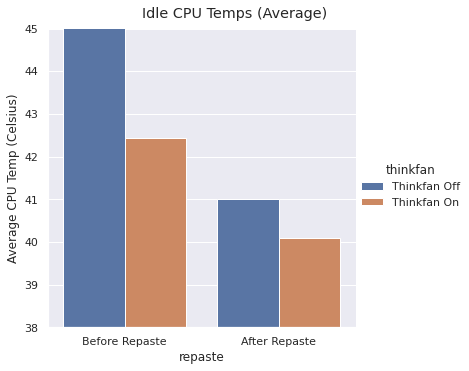

In [10]:
g = sns.catplot(data=idle_averages, x='repaste', hue='thinkfan', y='average_cpu', kind='bar', height=5)
g.fig.subplots_adjust(top=0.92)
g.fig.suptitle('Idle CPU Temps (Average)')
plt.ylabel('Average CPU Temp (Celsius)')
g.set(ylim=(38, 45))

Text(0.5, 0.98, 'Geekbench Scores')

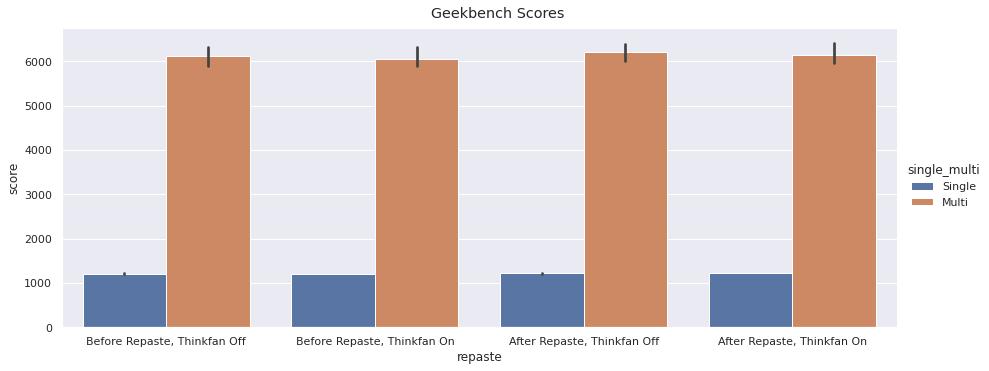

In [11]:
performance = pd.DataFrame(columns=['single_multi', 'repaste', 'score'])


# Ideally, do this less dumbly

performance.loc[len(performance)] = {
    'single_multi': 'Single',
    'repaste': 'Before Repaste, Thinkfan Off',
    'score': 1220
}
performance.loc[len(performance)] = {
    'single_multi': 'Multi',
    'repaste': 'Before Repaste, Thinkfan Off',
    'score': 6315
}
performance.loc[len(performance)] = {
    'single_multi': 'Single',
    'repaste': 'Before Repaste, Thinkfan Off',
    'score': 1211
}
performance.loc[len(performance)] = {
    'single_multi': 'Multi',
    'repaste': 'Before Repaste, Thinkfan Off',
    'score': 6147
}
performance.loc[len(performance)] = {
    'single_multi': 'Single',
    'repaste': 'Before Repaste, Thinkfan Off',
    'score': 1197
}
performance.loc[len(performance)] = {
    'single_multi': 'Multi',
    'repaste': 'Before Repaste, Thinkfan Off',
    'score': 5897
}


performance.loc[len(performance)] = {
    'single_multi': 'Single',
    'repaste': 'Before Repaste, Thinkfan On',
    'score': 1213
}
performance.loc[len(performance)] = {
    'single_multi': 'Multi',
    'repaste': 'Before Repaste, Thinkfan On',
    'score': 6316
}
performance.loc[len(performance)] = {
    'single_multi': 'Single',
    'repaste': 'Before Repaste, Thinkfan On',
    'score': 1194
}
performance.loc[len(performance)] = {
    'single_multi': 'Multi',
    'repaste': 'Before Repaste, Thinkfan On',
    'score': 5949
}
performance.loc[len(performance)] = {
    'single_multi': 'Single',
    'repaste': 'Before Repaste, Thinkfan On',
    'score': 1195
}
performance.loc[len(performance)] = {
    'single_multi': 'Multi',
    'repaste': 'Before Repaste, Thinkfan On',
    'score': 5903
}


performance.loc[len(performance)] = {
    'single_multi': 'Single',
    'repaste': 'After Repaste, Thinkfan Off',
    'score': 1230
}
performance.loc[len(performance)] = {
    'single_multi': 'Multi',
    'repaste': 'After Repaste, Thinkfan Off',
    'score': 6389
}
performance.loc[len(performance)] = {
    'single_multi': 'Single',
    'repaste': 'After Repaste, Thinkfan Off',
    'score': 1195
}
performance.loc[len(performance)] = {
    'single_multi': 'Multi',
    'repaste': 'After Repaste, Thinkfan Off',
    'score': 6255
}
performance.loc[len(performance)] = {
    'single_multi': 'Single',
    'repaste': 'After Repaste, Thinkfan Off',
    'score': 1218
}
performance.loc[len(performance)] = {
    'single_multi': 'Multi',
    'repaste': 'After Repaste, Thinkfan Off',
    'score': 6008
}


performance.loc[len(performance)] = {
    'single_multi': 'Single',
    'repaste': 'After Repaste, Thinkfan On',
    'score': 1226
}
performance.loc[len(performance)] = {
    'single_multi': 'Multi',
    'repaste': 'After Repaste, Thinkfan On',
    'score': 6419
}
performance.loc[len(performance)] = {
    'single_multi': 'Single',
    'repaste': 'After Repaste, Thinkfan On',
    'score': 1218
}
performance.loc[len(performance)] = {
    'single_multi': 'Multi',
    'repaste': 'After Repaste, Thinkfan On',
    'score': 6070
}
performance.loc[len(performance)] = {
    'single_multi': 'Single',
    'repaste': 'After Repaste, Thinkfan On',
    'score': 1217
}
performance.loc[len(performance)] = {
    'single_multi': 'Multi',
    'repaste': 'After Repaste, Thinkfan On',
    'score': 5960
}

g = sns.catplot(data=performance, x='repaste', hue='single_multi', y='score', kind='bar', height=5, aspect=2.5)
g.fig.subplots_adjust(top=0.92)
g.fig.suptitle('Geekbench Scores')

In [202]:
before_thinkfan_files = glob.glob('before/thinkfan/geekbench_*.csv')
before_no_thinkfan_files = glob.glob('before/no_thinkfan/geekbench_*.csv')
after_thinkfan_files = glob.glob('after/thinkfan/geekbench_*.csv')
after_no_thinkfan_files = glob.glob('after/no_thinkfan/geekbench_*.csv')

before_no_thinkfan = pd.DataFrame()
before_thinkfan = pd.DataFrame()
after_no_thinkfan = pd.DataFrame()
after_thinkfan = pd.DataFrame()


for file in before_no_thinkfan_files:
    before_no_thinkfan = pd.concat([before_no_thinkfan, pd.read_csv(file)])
    
for file in before_thinkfan_files:
    before_thinkfan = pd.concat([before_thinkfan, pd.read_csv(file)])

for file in after_no_thinkfan_files:
    after_no_thinkfan = pd.concat([after_no_thinkfan, pd.read_csv(file)])

for file in after_thinkfan_files:
    after_thinkfan = pd.concat([after_thinkfan, pd.read_csv(file)])

before_no_thinkfan = convert_to_numeric(before_no_thinkfan)
before_thinkfan = convert_to_numeric(before_thinkfan)
after_no_thinkfan = convert_to_numeric(after_no_thinkfan)
after_thinkfan = convert_to_numeric(after_thinkfan)

after_thinkfan

,Unnamed: 0,timestamp,cpu,gpu,fan
0,0,2021-06-14 18:03:02.117558,42.0,41.0,3100
1,1,2021-06-14 18:03:03.172265,52.0,41.0,3100
2,2,2021-06-14 18:03:04.231245,50.0,41.0,3100
3,3,2021-06-14 18:03:05.280282,48.0,41.0,2900
4,4,2021-06-14 18:03:06.337934,47.0,42.0,3200
...,...,...,...,...,...
149,149,2021-06-14 18:08:16.317684,69.0,59.0,5600
150,150,2021-06-14 18:08:17.377080,79.0,56.0,5500
151,151,2021-06-14 18:08:18.436992,78.0,60.0,5600
152,152,2021-06-14 18:08:19.516284,76.0,56.0,5500


In [206]:
def process_df(df):
    df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
    pd.melt(df, 'timestamp')
    df = df.drop('fan', axis=1)
    return df

before_no_thinkfan = process_df(before_no_thinkfan)
before_thinkfan = process_df(before_thinkfan)
after_no_thinkfan = process_df(after_no_thinkfan)
after_thinkfan = process_df(after_thinkfan)

Text(0, 0.5, 'Temperature (Celsius))')

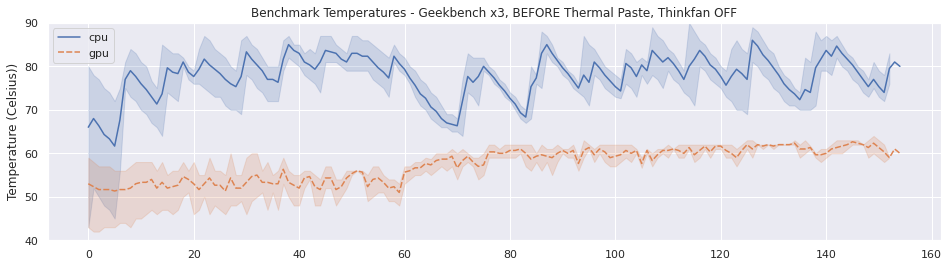

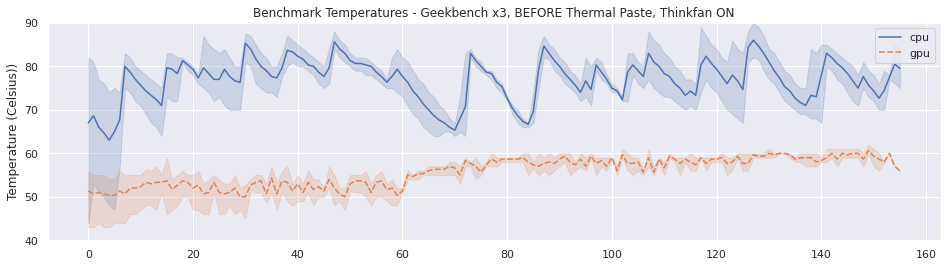

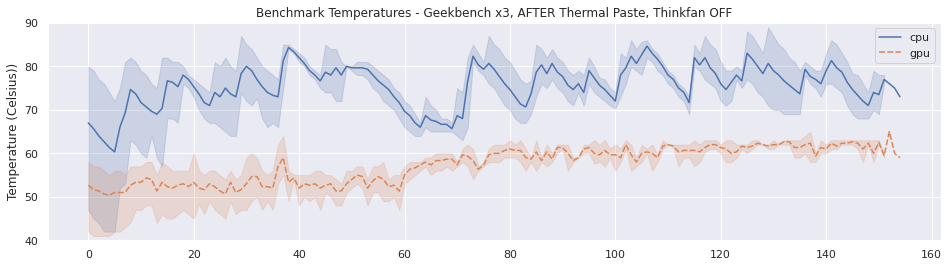

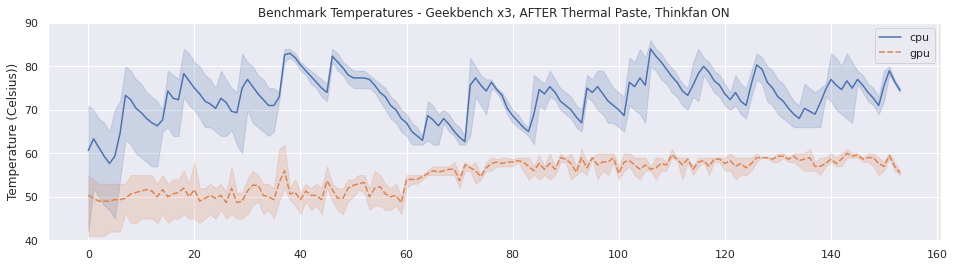

In [213]:
fig, ax1 = plt.subplots(figsize = (16, 4))
plt.yticks(np.arange(40, 91, 10))
plt.ylim(40, 90)
sns.lineplot(data=before_no_thinkfan).set_title('Benchmark Temperatures - Geekbench x3, BEFORE Thermal Paste, Thinkfan OFF')
plt.ylabel('Temperature (Celsius))')


fig, ax1 = plt.subplots(figsize = (16, 4))
plt.yticks(np.arange(40, 91, 10))
plt.ylim(40, 90)
sns.lineplot(data=before_thinkfan).set_title('Benchmark Temperatures - Geekbench x3, BEFORE Thermal Paste, Thinkfan ON')
plt.ylabel('Temperature (Celsius))')


fig, ax1 = plt.subplots(figsize = (16, 4))
plt.yticks(np.arange(40, 91, 10))
plt.ylim(40, 90)
sns.lineplot(data=after_no_thinkfan).set_title('Benchmark Temperatures - Geekbench x3, AFTER Thermal Paste, Thinkfan OFF')
plt.ylabel('Temperature (Celsius))')


fig, ax1 = plt.subplots(figsize = (16, 4))
plt.yticks(np.arange(40, 91, 10))
plt.ylim(40, 90)
sns.lineplot(data=after_thinkfan).set_title('Benchmark Temperatures - Geekbench x3, AFTER Thermal Paste, Thinkfan ON')
plt.ylabel('Temperature (Celsius))')

# ax2 = plt.twinx()
# plt.ylim(0, 5600)
# plt.ylabel('Fan Speed (RPM)')

# sns.lineplot(data=before_thinkfan, x='timestamp', y='fan', ax=ax2, color='black')